In [ ]:
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.6 MB/s eta 0:00:00


In [ ]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import glob
import json, onnxruntime as ort, numpy as np

In [ ]:
base_dir = Path("/content/drive/MyDrive/TAQA/eval/P8-36")
csv_paths = sorted(base_dir.glob('*.csv'))

frames= []
for file in tqdm(csv_paths, desc="Reading"):
  df = pd.read_csv(file, parse_dates = ['Timestamp'])

  value_col = df.columns[1]
  df = df.rename(columns={value_col: 'Value'})[['Timestamp', 'Value']]

  parts = file.stem.split('.')
  _,tool,kind,param = parts
  df['Tool'] = tool
  df['Kind'] = kind
  df['param']= param
  frames.append(df)

raw = pd.concat(frames, ignore_index=True)

wide = (raw.pivot_table(index=['Tool', 'Timestamp'],columns= 'param', values='Value').reset_index())
cols = ['Timestamp', 'Tool'] + [c for c in wide.columns if c not in ('Timestamp', 'Tool')]
wide = wide[cols]
print(wide.shape)
wide.head()

Reading: 100%|██████████| 7/7 [00:11<00:00,  1.69s/it]


(226756, 9)


param,Timestamp,Tool,Battery-Voltage,Choke-Position,Downstream-Pressure,Downstream-Temperature,Downstream-Upstream-Difference,Upstream-Pressure,Upstream-Temperature
0,2024-09-20 11:56:10.266816500+00:00,P8-36,10.15,100.00,32.6,19.74,-17.86,14.74,19.74
1,2024-09-20 11:56:11.287249800+00:00,P8-36,10.15,99.97,32.6,19.74,-17.86,14.74,19.74
2,2024-09-20 11:56:12.289814300+00:00,P8-36,10.15,100.00,32.6,19.74,-17.86,14.74,19.74
3,2024-09-20 11:56:13.310007800+00:00,P8-36,10.15,99.97,32.6,19.74,-17.86,14.74,19.74
4,2024-09-20 11:56:14.314148500+00:00,P8-36,10.15,100.00,32.6,19.74,-17.85,14.74,19.74


In [ ]:
CHOKE_OPEN_THRESHOLD = 10.0
df = (
    wide
      .drop(columns=["Tool","param"], errors="ignore")   # not features
      .set_index("Timestamp")                           # use time as index
      .sort_index()
      .astype(np.float32)                             # ONNX likes float32
)


# 3⃣  Add IsOpen flag based on Choke-Position ------------------------------
df["IsOpen"] = (df["Choke-Position"] > CHOKE_OPEN_THRESHOLD).astype(int)

# 4⃣  Derived helper columns (optional but handy) --------------------------
df["DeltaTemperature"]  = (
    df["Upstream-Temperature"] - df["Downstream-Temperature"]
)

df.head(3)


param,Battery-Voltage,Choke-Position,Downstream-Pressure,Downstream-Temperature,Downstream-Upstream-Difference,Upstream-Pressure,Upstream-Temperature,IsOpen,DeltaTemperature
Timestamp,,,,,,,,,
2024-09-20 11:56:10.266816500+00:00,10.15,100.000000,32.599998,19.74,-17.860001,14.74,19.74,1,0.0
2024-09-20 11:56:11.287249800+00:00,10.15,99.970001,32.599998,19.74,-17.860001,14.74,19.74,1,0.0
2024-09-20 11:56:12.289814300+00:00,10.15,100.000000,32.599998,19.74,-17.860001,14.74,19.74,1,0.0


In [ ]:
open_mask = df['IsOpen'] == 1
shut_mask = ~open_mask

X_choke = df[["Choke-Position"]].values

# 1-D IF – ΔT on open rows only
X_deltaT_open = df.loc[open_mask, ["DeltaTemperature"]].values

# 2-D IF – pressure pair (open rows)
X_pair_open = df.loc[open_mask,
                     ["Upstream-Pressure", "Downstream-Pressure"]].values


# residual feature vector (use the exact order your residual models expect)
X_res = df[["Upstream-Pressure", "Downstream-Pressure", "Upstream-Temperature", "Downstream-Temperature", "Choke-Position", "Downstream-Upstream-Difference"]].values

# 7-D IF – full vector
X_full = df[["Battery-Voltage",
             "Upstream-Pressure", "Downstream-Pressure",
             "Downstream-Upstream-Difference",
             "Upstream-Temperature", "Downstream-Temperature",
             "Choke-Position"]].values

In [ ]:
# 1 ▸ POINT TO THE FILE — make sure this is a Path object
models_dir = Path('/content/drive/MyDrive/TAQA/models')

# 3 ▸ BUILD A SIMPLE {signal: cutoff} DICT
mad_limits = json.load(open(models_dir / "residual_mad.json"))
print("Loaded MAD limits:", mad_limits)


Loaded MAD limits: {'Battery-Voltage': {'mad': 0.0084381103515625, 'cutoff': 0.03375244140625}, 'Upstream-Pressure': {'mad': 2.3722848892211914, 'cutoff': 9.489139556884766}, 'Downstream-Pressure': {'mad': 1.6075630187988281, 'cutoff': 6.4302520751953125}, 'Upstream-Temperature': {'mad': 0.011494636535644531, 'cutoff': 0.045978546142578125}, 'Downstream-Temperature': {'mad': 0.011046409606933594, 'cutoff': 0.044185638427734375}}


In [ ]:
def run_if_alert(onnx_name, X):
    X = X.astype(np.float32, copy=False)
    sess = ort.InferenceSession((models_dir/onnx_name).as_posix(),
                                providers=["CPUExecutionProvider"])
    labels = sess.run(None, {"input": X})[0].squeeze()  # output_label
    return labels == -1

In [ ]:
  # 1️⃣  Isolation-Forest alerts  ----------------------------------
alerts = {
    "IF_Choke"       : run_if_alert("choke_position.onnx",       X_choke),

    "IF_DeltaT_Open" : run_if_alert("delta_temp_open.onnx",      X_deltaT_open),

    "IF_Pair_Open"   : run_if_alert("pressure_pair_open.onnx",   X_pair_open),
      # "IF_Full"       : run_if_alert("full_vectors_if.onnx",
      #                               df[["BatteryVoltage","UpP","DownP","DeltaP",
      #                                   "UpT","DownT","ChokePosition"]].values),
  }

In [ ]:
def residual_alert(onnx_name: str, target_col: str):
    """
    Returns a boolean mask (len = len(df)) where residual > MAD cut-off.
    ONNX metadata key 'feature_names' lists the predictors in order.
    """
    onnx_path = models_dir / onnx_name
    sess      = ort.InferenceSession(onnx_path.as_posix(),
                                     providers=['CPUExecutionProvider'])

    order_str = sess.get_modelmeta().custom_metadata_map["feature_names"]
    feature_order = order_str.split(',')                 # list of 5 or 6 names

    X   = df[feature_order].astype(np.float32).values
    y   = df[target_col].astype(np.float32).values
    y_hat   = sess.run(None, {"input": X})[0].squeeze()

    resid  = np.abs(y - y_hat)
    cutoff = mad_limits[target_col]["cutoff"]
    return resid > cutoff

# ──────────────────────────────────────────────────────────────
# 3 ·  Build residual alert masks
# ──────────────────────────────────────────────────────────────
residual_alerts = {
    "RES_BatteryVoltage"  : residual_alert("residual_battery.onnx",
                                           "Battery-Voltage"),

    "RES_UpP"             : residual_alert("residual_upP.onnx",
                                           "Upstream-Pressure"),

    "RES_DownP"           : residual_alert("residual_downP.onnx",
                                           "Downstream-Pressure"),

    "RES_UpT"             : residual_alert("residual_upT.onnx",
                                           "Upstream-Temperature"),

    "RES_DownT"           : residual_alert("residual_downT.onnx",
                                           "Downstream-Temperature"),
}

# ──────────────────────────────────────────────────────────────
# 4 ·  Combine with your Isolation-Forest masks
#     (assuming you already built IF alerts into `alerts`)
# ──────────────────────────────────────────────────────────────
alerts.update(residual_alerts)

alert_rates = pd.Series({k: v.mean()*100 for k, v in alerts.items()}).round(2)
display(alert_rates.sort_values())

,0
IF_Choke,4.03
IF_DeltaT_Open,6.01
IF_Pair_Open,12.77
RES_UpP,88.43
RES_DownP,89.84
RES_BatteryVoltage,93.27
RES_UpT,94.41
RES_DownT,96.25


In [ ]:
df.describe(percentiles=[.01, .25, .5, .75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
param,,,,,,,,,,
BatteryVoltage,397829.0,0.006081,0.292335,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.090000
ChokePosition,397829.0,87.296127,33.094284,-1.650000,-0.030000,100.029999,100.510002,100.650002,100.680000,100.809998
DownP,397829.0,1543.553589,1123.342163,-0.230000,-0.060000,1496.890015,1515.060059,1581.469971,7691.034395,10259.089844
DownT,397829.0,69.933998,22.923124,0.000000,17.940001,80.529999,80.660004,80.730003,81.269997,83.169998
DeltaP,397829.0,184.763748,1320.936157,-3523.379883,-3020.592090,-7.280000,-4.550000,-1.640000,7476.393340,8015.390137
UpP,397829.0,1728.317139,1557.389526,0.000000,15.020000,1490.150024,1513.260010,1579.959961,8278.524531,10268.830078
UpT,397829.0,71.329910,23.292095,0.000000,18.030001,81.839996,81.919998,81.980003,82.099998,82.160004
DeltaT,397829.0,1.395892,2.192976,-1.070000,-0.450001,1.139999,1.250000,1.290001,13.660000,23.790005


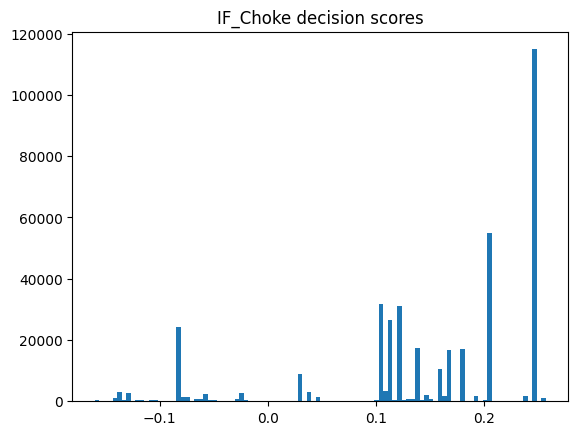

In [ ]:
import matplotlib.pyplot as plt
plt.hist(scores["IF_Choke"], 100); plt.title("IF_Choke decision scores");

In [ ]:
yp = ort.InferenceSession("residual_upP.onnx").run(None, {"input": df[meta_cols].values})[0].squeeze()
print("Pred median:", np.median(yp), "  Actual median:", df["Upstream-Pressure"].median())



NoSuchFile: [ONNXRuntimeError] : 3 : NO_SUCHFILE : Load model from residual_upP.onnx failed:Load model residual_upP.onnx failed. File doesn't exist

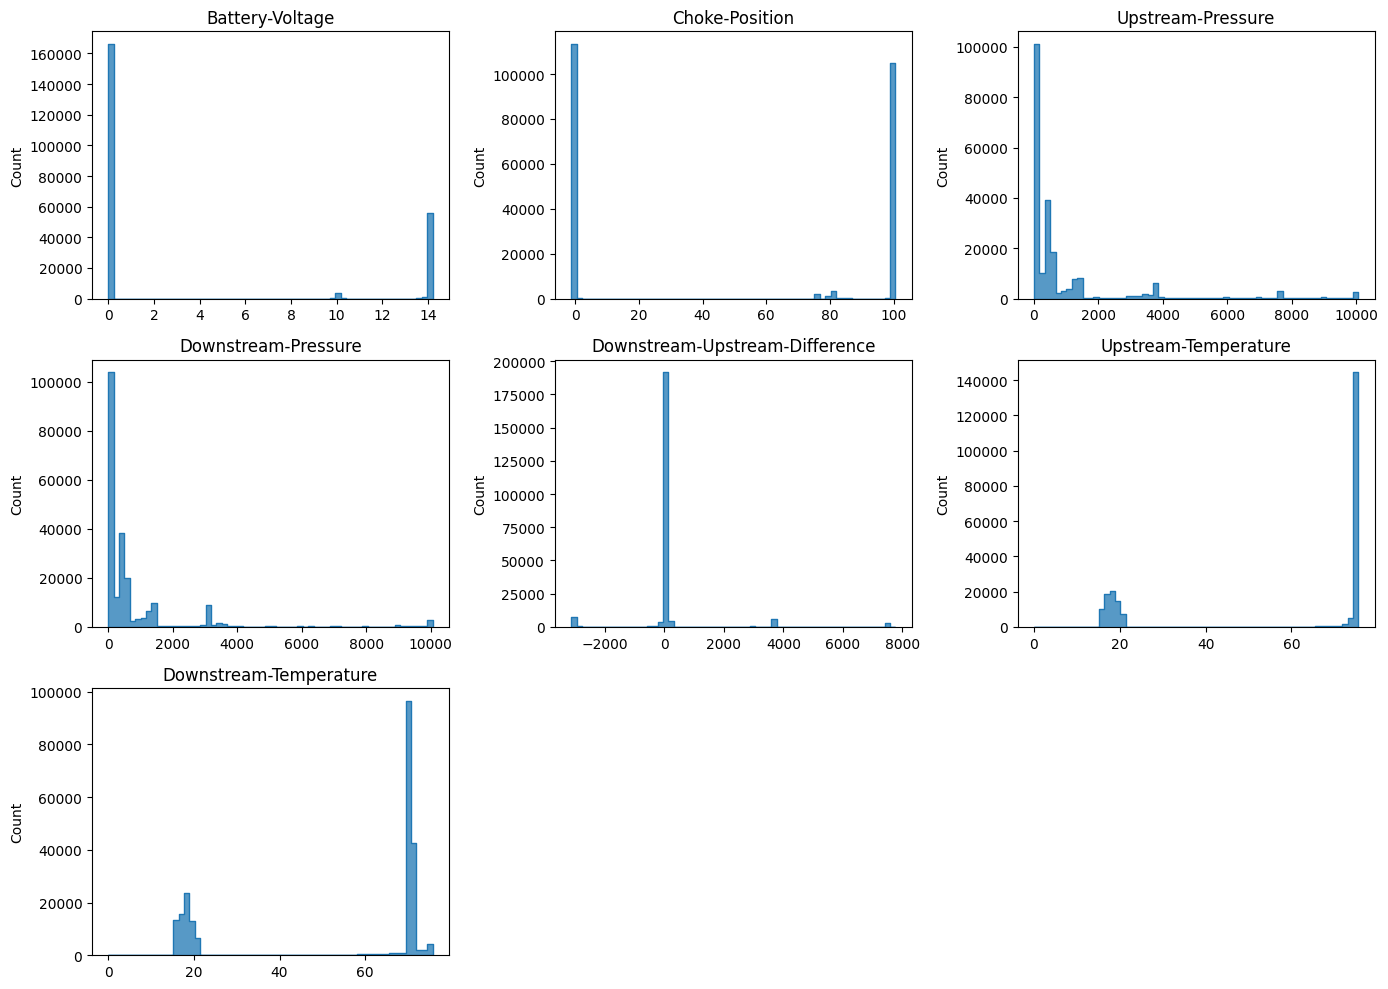

In [ ]:
import seaborn as sns, matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,4)
palette = sns.color_palette('Set2', n_colors=raw['Tool'].nunique())
PARAMS = ['Battery-Voltage', 'Choke-Position',
          'Upstream-Pressure', 'Downstream-Pressure',
          'Downstream-Upstream-Difference',
          'Upstream-Temperature', 'Downstream-Temperature']

#tools   = sorted(raw_nd['Tool'].unique())
#pal     = dict(zip(tools, sns.color_palette('husl', len(tools))))

fig, axes = plt.subplots(3, 3, figsize=(14, 10), sharey=False)
axes = axes.flatten()

for ax, p in zip(axes, PARAMS):
    sns.histplot(data   = df,
                 x      = p,
                 #hue    = 'Tool',
                 bins   = 60,
                 #palette= pal,
                 multiple='layer',   # outlines separated
                 element='step',
                 ax=ax,
                 stat='count',
                 common_norm=False)

    ax.set_title(p)
    ax.set_xlabel('')
    #ax.legend(title='Tool', fontsize='small', frameon=False, labels=sorted(raw_nd['Tool'].unique()))


for ax in axes[len(PARAMS):]:
    ax.axis('off')

fig.tight_layout()
plt.show()

In [ ]:
def debug_residual(onnx_name, target_col):
    sess  = ort.InferenceSession((models_dir/onnx_name).as_posix())
    order = sess.get_modelmeta().custom_metadata_map["feature_names"].split(',')
    X     = df[order].astype(np.float32).values
    y_pred= sess.run(None, {"input": X})[0].squeeze()
    print("Feature order :", order[:6], "...")
    print("Pred  median  :", np.median(y_pred))
    print("Actual median :", df[target_col].median())
    return order

order_upP = debug_residual("residual_upP.onnx", "Upstream-Pressure")


Feature order : ['Downstream-Pressure', 'Upstream-Temperature', 'Downstream-Temperature', 'Choke-Position', 'Downstream-Upstream-Difference', 'Battery-Voltage'] ...
Pred  median  : 423.1586
Actual median : 414.9800109863281


In [ ]:
sess = ort.InferenceSession((models_dir / "residual_upP.onnx").as_posix(),
                            providers=["CPUExecutionProvider"])
order = sess.get_modelmeta().custom_metadata_map["feature_names"].split(',')
print("ONNX expects →", order)

#-- the array you really feed
X_eval = df[order].astype(np.float32).values        # <- should be this
print("first row   →", X_eval[0])


ONNX expects → ['Downstream-Pressure', 'Upstream-Temperature', 'Downstream-Temperature', 'Choke-Position', 'Downstream-Upstream-Difference', 'Battery-Voltage']
first row   → [ 32.6   19.74  19.74 100.   -17.86  10.15]


In [ ]:
y_pred = sess.run(None, {"input": X_eval})[0].squeeze()
resid  = (df["Upstream-Pressure"].values - y_pred).__abs__()
cutoff = mad_limits["Upstream-Pressure"]["cutoff"]
print("alert % :", (resid > cutoff).mean()*100)


alert % : 88.43382314029176


In [ ]:
cutoff = mad_limits["Upstream-Pressure"]["cutoff"]
resid  = np.abs(df["Upstream-Pressure"].values - y_pred)

print("cut-off   :", cutoff)
print("resid 5/50/95 percentiles:",
      np.percentile(resid,[5,50,95]))


cut-off   : 9.489139556884766
resid 5/50/95 percentiles: [   3.7986145    30.60987854 1980.38244629]


In [ ]:
print("Battery  median :", df["Battery-Voltage"].median())
print("null counts    :", df[order].isna().sum().to_dict())

Battery  median : 0.0
null counts    : {'Downstream-Pressure': 0, 'Upstream-Temperature': 0, 'Downstream-Temperature': 0, 'Choke-Position': 0, 'Downstream-Upstream-Difference': 0, 'Battery-Voltage': 0}


In [ ]:
total  = len(df)
zeros  = (df["Battery-Voltage"] == 0).sum()
print(f"rows with 0 V : {zeros:,}  ({zeros/total:.1%} of the data)")
print(df["Battery-Voltage"].describe())      # full five-number summary

rows with 0 V : 166,143  (73.3% of the data)
count    226756.000000
mean          3.721076
std           6.190262
min           0.000000
25%           0.000000
50%           0.000000
75%          13.600000
max          14.200000
Name: Battery-Voltage, dtype: float64
